# Neural network to classify ASD in children
## 1. Importing packages

In [38]:
# system tools
import os

# pytorch
os.system('pip install --upgrade pip datasets torch')
import torch
import torch.nn as nn

# data processing
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from datasets import Dataset

# huggingface datasets
from datasets import load_dataset

# scikit learn tools
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.feature_extraction.text import CountVectorizer #xxx remove one of these when you have tested to see which one is better.

# plotting tools
import matplotlib.pyplot as plt

Defaulting to user installation because normal site-packages is not writeable
  Using cached pip-22.3.1-py3-none-any.whl (2.1 MB)


## 2. Defining our neural network in a model class

In [39]:

class NeuralNetwork(nn.Module):
    """ class initializing a fully-connected neural network with 
    three layers: 1) one input layer, 2) one hidden layer with 
    xxx nodes and 3) one output layer with one node
    """
    def __init__(self, n_input_features):
        super().__init__()
        self.linear1 = nn.Linear(n_input_features, 30) # xxx The network should probably be made smaller than this due to our data.
        self.linear2 = nn.Linear(30, 30)
        self.linear3 = nn.Linear(30, 1)

    def forward(self, x):
        leaky_relu = nn.LeakyReLU(0.2)
        # Linear -> ReLU
        x = self.linear1(x)
        x = leaky_relu(x)
        # Linear -> ReLU
        x = self.linear2(x)
        x = leaky_relu(x)
        # Linear -> Sigmoid
        x = self.linear3(x)
        y_pred = torch.sigmoid(x)
        return y_pred

## 3. Loading and preprocessing the data

In [40]:
def split_data(data_path):
    """ A function that loads the "raw" dataframe and splits it into three subsets:
    training, validation, and test data.
    NB: The data is not really raw - the TalkBank data has been preprocessed - see xxx.
    """
    # Import the dataframe
    data = pd.read_csv(data_path)

    # Split dataset into train, test, val (70, 15, 15)
    train, test = train_test_split(data, test_size=0.15)
    train, val = train_test_split(train, test_size=0.15)

    # Turning the split dataframes into dicts
    train = Dataset.from_dict(train)
    val = Dataset.from_dict(val)
    test = Dataset.from_dict(test)
    
    return train, val, test

## 4. Vectorize (TF-IDF model)

In [41]:
def TF_IDF():
    """ This function creates a TF-IDF model of the training, 
    validation, and test sets using sklearn's TfidfVectorizer.
    """

    train, val, test = split_data("/work/exam/ASD_classification/data/dataframes/data_eigstig_age3_text_label.csv")
    
    # Load the vectorizer from sklearn
    vectorizer = TfidfVectorizer(ngram_range = (1,2), # xxx What does this mean?
                                #lowercase = True,
                                max_df = 0.9, # xxx What do these two mean?
                                min_df = 0.1,
                                max_features = 500) # xxx Keeping only the top 500 features in the dataset. Might improve performance
    #vectorizer = CountVectorizer(max_features=500) # If end up you using this vectorizer, then you need to rename the function and rewrite the documentation.

    # Vectorizing the datasets
    X_train = vectorizer.fit_transform(train["text"]) # train_vect
    X_val = vectorizer.transform(val["text"]) # val_vect
    X_test = vectorizer.transform(test["text"]) # test_vect
    
    # Turning the vectorized data into tensors
    ## Training data:
    X_train = torch.tensor(X_train.toarray(), dtype = torch.float)
    y_train = torch.tensor(list(train["label"]), dtype = torch.float)
    y_train = y_train.view(y_train.shape[0], 1)

    ## Validation data:
    X_val = torch.tensor(X_val.toarray(), dtype = torch.float)
    y_val = torch.tensor(list(val["label"]), dtype = torch.float)
    y_val = y_val.view(y_val.shape[0], 1)

    ## Test data:
    X_test = torch.tensor(X_test.toarray(), dtype = torch.float)
    y_test = torch.tensor(list(test["label"]), dtype = torch.float)
    y_test = y_test.view(y_test.shape[0], 1)

    return X_train, y_train, X_val, y_val, X_test, y_test

## 5. Set parameters

In [ ]:
# X_train, y_train, X_val, y_val, X_test, y_test = TF_IDF()

# # Calculate weights using sklearn
# from sklearn.utils.class_weight import compute_class_weight

# sklearn_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
# sklearn_weights
# #array([ 0.50515894, 48.95960832])

In [50]:
######## Weights ########
# n_samples = 2435
# n_classes = 2 (0 and 1)
# n_sample0 (TD) = 1730
# n_samples1 (ASD) = 705

# Weights for class 0:
w0 = 2435/(2 * 1730)

#Weights for class 1:
w1 = 2435/(2 * 705)

print("TD weight =", w0, ", ASD weight =", w1)

weights = {0 : w0, 1 : w1}

TD weight = 0.703757225433526 , ASD weight = 1.7269503546099292


In [42]:
# xxx It is in this function that it needs to happen, if you want to be able to run both the lr and the nn from the same script (see our own assignment 3)

def initializeModel(X_train):
    # Initialize model
    n_samples, n_features = X_train.shape
    model = NeuralNetwork(n_input_features = n_features)

    # Define loss and optimizer
    criterion = nn.BCELoss() # xxx weights?
    optimizer = torch.optim.AdamW(model.parameters(),
                                #lr=1e-4) #xxx
                                lr=1e-3) 
    
    return n_features, criterion, optimizer, model

## 6. Training the model

In [43]:
def saveModel(model): 
    """ Function for saving the trained model.
    Args:
        model (Module): pytorch model to be saved
    """
    path = os.path.join("/work", "exam", "ASD_classification", "out", "NetModel_nn.pth")
    torch.save(model.state_dict(), path)


In [44]:
def train(epochs, plot = True):

    # Initialize the nn
    n_features, criterion, optimizer, model = initializeModel(X_train)
    
    print("[INFO:] Training classifier...")

    # These are used for plotting the loss
    train_loss_history = []
    val_loss_history = []
    # And these are used for saving the model
    running_accuracy = 0.0 
    running_val_loss = 0.0 
    total = 0 
    best_accuracy = 0.0

    # Looping over the epochs
    for epoch in range(epochs):

        # Forward
        y_train_hat = model(X_train)

        # Backward
        train_loss = criterion(y_train_hat, y_train)
        train_loss_history.append(train_loss)

        # Backpropagation
        train_loss.backward()

        # Take a step and reset
        optimizer.step()
        optimizer.zero_grad()

        # Printing to make sure that it is running
        if (epoch + 1) % 100 == 0:
            print(f"epoch: {epoch+1}, train_loss = {train_loss.item():.4f}")
        
        # Validation loop
        with torch.no_grad():

            # Set to evaluation mode to ensure that the model does not forward pass over and learn from the validation data
            model.eval()

            # Make predictions
            y_val_hat = model(X_val) # aka predicted_outputs

            # Computing the metrics
            val_loss = criterion(y_val_hat, y_val)
            val_loss_history.append(val_loss)

            
            ## This part is for saving the model, so we can use it for testing
            # the label with the highest value will be our prediction 
            _, predicted = torch.max(y_val_hat, 1) 
            running_val_loss += val_loss.item()  
            total += y_val.size(0) 
            running_accuracy += (predicted == y_val).sum().item()
                    
        # calculate accuracy as the number of correct predictions in the validation batch divided by the total number of predictions done.  
        accuracy = (100 * running_accuracy / total)     
    
        # save the model if the accuracy is the best 
        if accuracy > best_accuracy: 
            saveModel(model) 
            best_accuracy = accuracy 
    
    if plot:
        # plotting training and validation loss
        loss_train = [val.item() for val in train_loss_history]
        loss_val = [val.item() for val in val_loss_history]
        fig, ax = plt.subplots()
        ax.plot(loss_train, label = 'train')
        ax.set_title('Loss history')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.plot(loss_val, label = 'val')
        ax.legend()
        plt.savefig(os.path.join("/work", "exam", "ASD_classification", "out", "loss_curve_nn.png"))
    
    print("[INFO:] Finished traning!")

    return model


## 7. Testing/evaluating the model

In [45]:
def test(n_features, model):
    """ Function to evaluate model on test set
    Args:
        n_features (int): number of features
    """
    # testing on the best model
    path = os.path.join("/work", "exam", "ASD_classification", "out", "NetModel_nn.pth")
    model.load_state_dict(torch.load(path)) 
    predicted = model(X_test).detach().numpy()

    # printing and saving classification report
    out = classification_report(y_test, 
                        np.where(predicted > 0.5, 1, 0),
                        target_names = ["TD", "ASD"])
    
    print(out) 

    with open(os.path.join("/work", "exam", "ASD_classification", "out", "classification_report_nn.txt"), 'w') as f:
        f.write(out)

## 8. Main

[INFO:] Training classifier...
epoch: 100, train_loss = 0.6064
[INFO:] Finished traning!
              precision    recall  f1-score   support

          TD       0.74      1.00      0.85       270
         ASD       0.00      0.00      0.00        96

    accuracy                           0.74       366
   macro avg       0.37      0.50      0.42       366
weighted avg       0.54      0.74      0.63       366



/home/coder/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/coder/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/coder/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


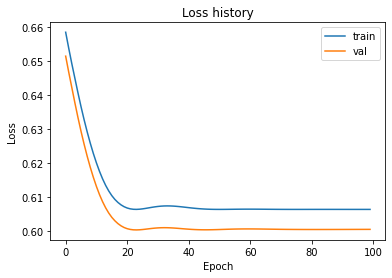

In [46]:
if __name__ == "__main__": 

    # Splitting into separate datasets
    X_train, y_train, X_val, y_val, X_test, y_test = TF_IDF()
    _, n_features = X_train.shape

    # training the model
    model = train(epochs = 100)

    test(n_features, model)